# Sentiment Analysis of Reddit Data

### Does mood fluctuate throughout the day?

My strategy for trying to understand this question is to calculate sentiment scores from posts in the r/depression subreddit. I thought that the best way to tease out any releationship would be to analyze people who are at the more extreme ends of the mood spectrum. Each post on reddit is then time stamped, so I will be able to perform a statistical analysis on the sentiment scores throughout the day. After I gather Reddit post data I will feed it through a sentiment analysis model, and my output will be scores of negative, neutral, and positive sentiment scores.

### Literature

Sentiment analysis is an NLP (Natural Language Processing) technique used generally to determine if human speach is positive, negative, or neutral. Oftentimes sentiment analysis wil use a machine learning trained model to determine the sentiment. Many of the more inpactful papers in this field began to appear in the early 2000's, but work was underway in this topic as early as the 1950's. One of the most impactful papers with 12,000 citations is ["opinion mining and sentiment analysis"](https://www.cs.cornell.edu/home/llee/omsa/omsa.pdf), 2008 (Bo Pang, Lillian Lee) where they describe many ML and tradititional classification technique for sentiment analysis. Many others have analyzed social media data for sentiment, my approach is novel because as far as I can tell no one else has tried to use sentiment analysis to investigate mood fluctuations. 

## Gathering Data

To gather the data I will be using in this analysis I used the Reddit API. When using the API you can specify which headers to grab from each post. 

I choose:

**Title** &rarr; Title of the Reddit post

**selftext** &rarr; Body of the reddit post

**created_utc** &rarr; Time the reddit post was created in seconds since unix epoch

**num_comments** &rarr; Number of comments on reddit post

**upvote_ratio** &rarr; Upvotes divided by down votes

**ups** &rarr; Number of upvotes

**downs** &rarr; Number of downvotes

**id** &rarr; Post id

**kind** &rarr; Another identifier of the reddit post

NOTE: All keys and identifiers have been replaced with "xxx"

### Authentication for Redddit API

### Data gathering from reddit api, saving as a data table

## Cleaning the Data

In [18]:
import pandas as pd
import seaborn as sns
import nltk
import contractions
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import datetime
import pytz
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/anthony/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/anthony/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/anthony/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/anthony/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

The original text data when pulling from the reddit API had both emojis and non ascii characters. The code chunk below cleans all the reddit posts to only contain ascii characters. Luckily in this data set I did not have to worry about missing data values because I pulled this from the Reddit API, and reddit ensures all posts have data for every header.

In [4]:
posts_df = pd.read_csv("RedditData.csv")

# Keeps only ascii characters
def clean_txt(row):
    return row.encode('ascii', 'ignore').decode('ascii')

posts_df["cleaned_text"] = posts_df["selftext"].apply(lambda x: clean_txt(x))


Next I wanted to make a word cloud so that I could get an initial sense of what the sentiment in the posts overall might be. To prepare I needed to tokanize and then clean the post data even further using the nltk package.

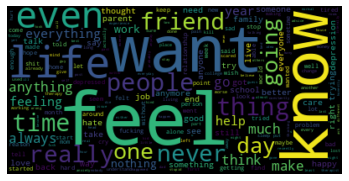

In [5]:
# Cleans text to be used in word cloud
def wordcloud_clean(row):
    row = contractions.fix(row)

    tokens = word_tokenize(row)
    tokens = [w.lower() for w in tokens]
    stop_words = set(stopwords.words('english'))
    words = [w for w in tokens if not w in stop_words]

    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(w) for w in words]

    mystring = ' '.join(map(str, words))

    return mystring

posts_df["wordcloud_txt"] = posts_df["cleaned_text"].apply(lambda x: wordcloud_clean(x))

text = ""

for index, row in posts_df.iterrows():
    text += row['wordcloud_txt']

wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
posts_df.to_csv("RedditDataCleaned.csv")

Next I need to convert the time I got from the reddit API which is seconds since unix epoch into US central time so that I can split up reddit posts based on the time of day.

In [21]:
def convert_time(row):
        time = datetime.datetime.fromtimestamp(row)
        time = time.astimezone(pytz.timezone('US/Central')).strftime('%H')
        return time

posts_df["time"] = posts_df["created_utc"].apply(lambda x: convert_time(x))

posts_df.head()

,Unnamed: 0.1,Unnamed: 0,title,selftext,created_utc,num_comments,upvote_ratio,ups,downs,id,kind,cleaned_text,wordcloud_txt,scores,compound,neg,neu,pos,time,comp_score
0,0,0,Mood changes,I was diagnosed with major depressive disorder...,1.654825e+09,0,1.0,1,0,v8wabq,t3,I was diagnosed with major depressive disorder...,diagnosed major depressive disorder december l...,"{'neg': 0.108, 'neu': 0.777, 'pos': 0.115, 'co...",0.3818,0.108,0.777,0.115,20,pos
1,1,1,I just want to be normal again.,"I’ve been going through a tough time lately, t...",1.654824e+09,1,1.0,1,0,v8w68f,t3,"Ive been going through a tough time lately, th...","going tough time lately , ocd mine completely ...","{'neg': 0.062, 'neu': 0.863, 'pos': 0.074, 'co...",0.1635,0.062,0.863,0.074,20,neu
2,2,2,I can't leave my room. Advice?,I don't think I have depression? I don't wanna...,1.654824e+09,0,1.0,1,0,v8w01i,t3,I don't think I have depression? I don't wanna...,think depression ? want self-diagnose . sure p...,"{'neg': 0.138, 'neu': 0.695, 'pos': 0.166, 'co...",0.9471,0.138,0.695,0.166,20,strong_pos
3,3,3,I hate my family,"Hi, I don’t know who to talk to but I’ve been ...",1.654824e+09,0,1.0,1,0,v8vzfk,t3,"Hi, I dont know who to talk to but Ive been ha...","hi , know talk bad life . ever since high scho...","{'neg': 0.264, 'neu': 0.666, 'pos': 0.07, 'com...",-0.9960,0.264,0.666,0.070,20,strong_neg
4,4,4,I've had a very bad day today,"Lost my keys and card, being left out by group...",1.654823e+09,0,1.0,2,0,v8vw9r,t3,"Lost my keys and card, being left out by group...","lost key card , left group girl college , thre...","{'neg': 0.078, 'neu': 0.922, 'pos': 0.0, 'comp...",-0.3182,0.078,0.922,0.000,20,neg


## Sentiment Analysis

To perform the sentiment analysis I am using the VADER (Valence Aware Dictionary for Sentiment Reasoning) model from the nltk package. The model outputs a dictionary of negative, neutral, and positive sentiment scores as well as a composite score. After running the model on the Reddit data I then converted the output dictionary to four columns in the data frame.

In [22]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

posts_df['scores'] = posts_df['cleaned_text'].apply(lambda x: sid.polarity_scores(x))

posts_df['compound']  = posts_df['scores'].apply(lambda score_dict: score_dict['compound'])

posts_df['neg']  = posts_df['scores'].apply(lambda score_dict: score_dict['neg'])

posts_df['neu']  = posts_df['scores'].apply(lambda score_dict: score_dict['neu'])

posts_df['pos']  = posts_df['scores'].apply(lambda score_dict: score_dict['pos'])

def sentiment(row):
    if row >=.2 and row < .8:
        return 'pos'
    elif row >= .8:
        return 'strong_pos'
    elif row <= -.2 and row > -.8:
        return 'neg'
    elif row <= -.8:
        return 'strong_neg'
    else:
        return 'neu'

posts_df['comp_score'] = posts_df['compound'].apply(lambda x: sentiment(x))

posts_df.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/anthony/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Unnamed: 0.1,Unnamed: 0,title,selftext,created_utc,num_comments,upvote_ratio,ups,downs,id,kind,cleaned_text,wordcloud_txt,scores,compound,neg,neu,pos,time,comp_score
0,0,0,Mood changes,I was diagnosed with major depressive disorder...,1.654825e+09,0,1.0,1,0,v8wabq,t3,I was diagnosed with major depressive disorder...,diagnosed major depressive disorder december l...,"{'neg': 0.108, 'neu': 0.777, 'pos': 0.115, 'co...",0.3818,0.108,0.777,0.115,20,pos
1,1,1,I just want to be normal again.,"I’ve been going through a tough time lately, t...",1.654824e+09,1,1.0,1,0,v8w68f,t3,"Ive been going through a tough time lately, th...","going tough time lately , ocd mine completely ...","{'neg': 0.062, 'neu': 0.863, 'pos': 0.074, 'co...",0.1635,0.062,0.863,0.074,20,neu
2,2,2,I can't leave my room. Advice?,I don't think I have depression? I don't wanna...,1.654824e+09,0,1.0,1,0,v8w01i,t3,I don't think I have depression? I don't wanna...,think depression ? want self-diagnose . sure p...,"{'neg': 0.138, 'neu': 0.695, 'pos': 0.166, 'co...",0.9471,0.138,0.695,0.166,20,strong_pos
3,3,3,I hate my family,"Hi, I don’t know who to talk to but I’ve been ...",1.654824e+09,0,1.0,1,0,v8vzfk,t3,"Hi, I dont know who to talk to but Ive been ha...","hi , know talk bad life . ever since high scho...","{'neg': 0.264, 'neu': 0.666, 'pos': 0.07, 'com...",-0.9960,0.264,0.666,0.070,20,strong_neg
4,4,4,I've had a very bad day today,"Lost my keys and card, being left out by group...",1.654823e+09,0,1.0,2,0,v8vw9r,t3,"Lost my keys and card, being left out by group...","lost key card , left group girl college , thre...","{'neg': 0.078, 'neu': 0.922, 'pos': 0.0, 'comp...",-0.3182,0.078,0.922,0.000,20,neg


## Results

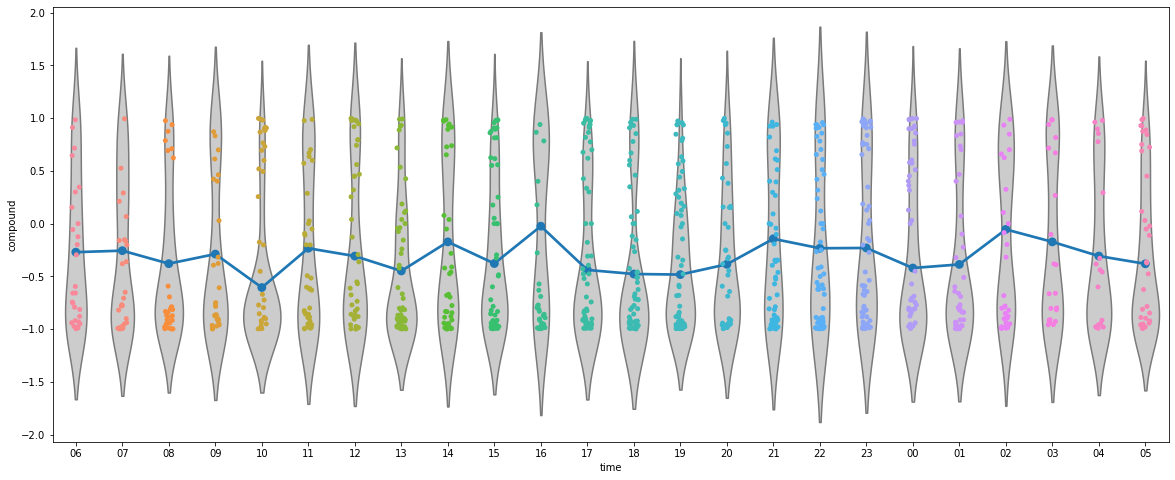

In [36]:
plt.figure(figsize = (20,8))

ax = sns.violinplot(x="time", y="compound", data=posts_df,
                    inner=None, color=".8")

ax = sns.pointplot(x="time", y="compound", data=posts_df, ci = None)

ax = sns.stripplot(x="time", y="compound", data=posts_df, order = 
                   ["06", "07", "08", "09","10","11", "12", "13", "14", "15", "16", "17", "18", "19", 
                    "20", "21", "22", "23", "00", "01", "02", "03", "04", "05"], jitter = True)